# Mixture of Two Gaussian Process Experts Example

This notebook is a basic example of configuring and training a mixture of two GP experts (using MixtureOfSVGPExperts) on the motorcycle dataset.

In [10]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt

from gpflow import default_float
from gpflow.utilities import print_summary

from mogpe.data.utils import load_mcycle_dataset
from mogpe.models.experts import SVGPExperts, SVGPExpert
from mogpe.models.gating_network import SVGPGatingFunction, SVGPGatingNetworkBinary
from mogpe.models.mixture_model import MixtureOfSVGPExperts
from mogpe.training.utils import training_tf_loop
from mogpe.visualization.plotter import Plotter1D

Let's start by configuring some of the model and training parameters.

In [11]:
num_inducing = 7
batch_size = 30
num_inducing_samples = 1
logging_epoch_freq = 100
num_epochs = 5000

Load the motorcycle dataset and plot it to see what we're dealing with.

Input data shape:  (133, 1)
Output data shape:  (133, 1)


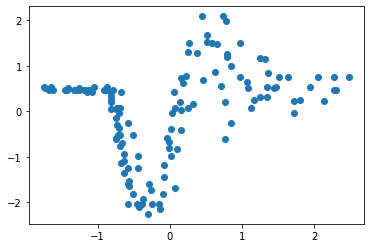

In [12]:
data_file = '../../data/external/mcycle.csv'
dataset = load_mcycle_dataset(filename=data_file)
X, Y = dataset
num_data = X.shape[0]
input_dim = X.shape[1]
output_dim = Y.shape[1]
plt.scatter(X, Y)

In order to initialie the MixtureOfSVGPExperts class for two experts we must pass it an instance of SVGPExperts and an instance of SVGPGatingNetworkBinary. Let's start by creating an instance of SVGPExperts. To do this we must first create two SVGPExpert instances and pass them as a list to SVGPExperts. Let's create out first expert. 

In [13]:
noise_var_1 = 0.9
kern_var_1 = 2.
lengthscale_1 = 0.5

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_1)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale_1 = tf.convert_to_tensor([lengthscale_1] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_1))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_1 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)

And now our second expert with a longer lengthscale and lower noise.

In [14]:
noise_var_2 = 0.0011
kern_var_2 = 0.1
lengthscale_2 = 10.

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_2)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale_2 = tf.convert_to_tensor([lengthscale_2] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_2))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_2 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)


We can now create an instance of SVGPExperts by passing our two experts as a list.

In [15]:
experts_list = [expert_1, expert_2]
experts = SVGPExperts(experts_list)
print_summary(experts)

╒═══════════════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════╤═════════╤═══════════════════════╕
│ name                                                              │ class     │ transform        │ prior   │ trainable   │ shape     │ dtype   │ value                 │
╞═══════════════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════╪═════════╪═══════════════════════╡
│ SVGPExperts.experts_list[0].mean_function.c                       │ Parameter │                  │         │ True        │ (1,)      │ float64 │ [0.]                  │
├───────────────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼───────────────────────┤
│ SVGPExperts.experts_list[0].kernel.kernels[0].variance            │ Parameter │ Softplus         │         │ True        │ ()        │ float64 

Lovely stuff. We now need to create an instance of SVGPGatingNetworkBinary which requires an instance of SVGPGatingFunction (a single gating function) for its construction. Remember that we only need a single gating function for the two expert case. Let's go ahead and create our gating function and use it to construct our gating network.

In [16]:
idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)

inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

noise_var = 0.1
lengthscale = 1.
mean_function = gpf.mean_functions.Zero()

q_mu = np.zeros((num_inducing, output_dim)) + np.random.randn(num_inducing, output_dim) * 2
q_sqrt = np.array([
    10 * np.eye(num_inducing, dtype=default_float())
    for _ in range(output_dim)
])

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale = tf.convert_to_tensor([lengthscale] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale))
kernel = gpf.kernels.SeparateIndependent(kern_list)

gating_function = SVGPGatingFunction(kernel,
                                     inducing_variable,
                                     mean_function,
                                     q_mu=q_mu,
                                     q_sqrt=q_sqrt)
gating_network = SVGPGatingNetworkBinary(gating_function)
print_summary(gating_network)

╒═══════════════════════════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤═══════════════════╕
│ name                                                                                  │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value             │
╞═══════════════════════════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪═══════════════════╡
│ SVGPGatingNetworkBinary.gating_function_list[0].kernel.kernels[0].variance            │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 1.0               │
├───────────────────────────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼───────────────────┤
│ SVGPGatingNetworkBinary.gating_function_list[0].kernel.kernels[0].lengths

We now have all the components to construct our MixtureOfSVGPExperts model so let's go ahead and do it. The num_inducing_samples variable defines how many samples should be drawn from the inducing point distributions during training.

In [17]:
model = MixtureOfSVGPExperts(gating_network=gating_network, experts=experts, num_inducing_samples=num_inducing_samples, num_data=num_data)

We can use the Plotter1D class from visualization to plot our model before training.

Plotting gating network...
Plotting experts y...
Plotting y...


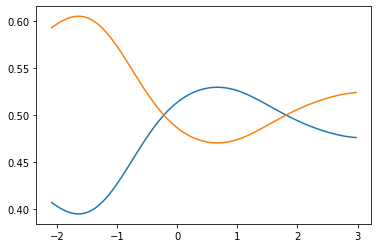

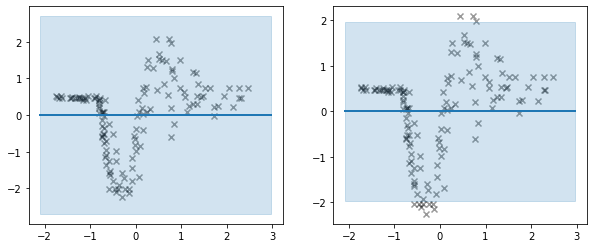

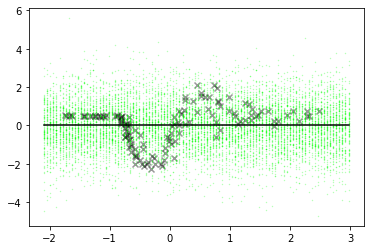

In [18]:
plotter = Plotter1D(model, X, Y)
plotter.plot_model()

We must now convert our numpy data set into a TensorFlow data set and set it up for stochastic optimisation by setting the batch size. We set drop_remainder=True to ensure the model receives the batch size.

In [19]:
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_data // 2
num_batches_per_epoch = num_data // batch_size
train_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = (train_dataset.repeat().prefetch(prefetch_size).shuffle(
    buffer_size=shuffle_buffer_size).batch(batch_size, drop_remainder=True))

We then use GPflows training_loss_closure method to get our training loss.

In [20]:
training_loss = model.training_loss_closure(iter(train_dataset))

In mogpe.training.utils four training loops are defined. Here we use the simple training_tf_loop which runs the Adam optimizer on model with training_loss as the objective function. The loop does not use any TensorBoard monitoring.

In [21]:
training_tf_loop(model,
                 training_loss,
                 epochs=num_epochs,
                 num_batches_per_epoch=num_batches_per_epoch,
                 logging_epoch_freq=logging_epoch_freq)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
mixing_probs
(1, 30, 1, 2)
batched dists
tfp.distributions.Normal("ELBO_predict_experts_prob_Normal", batch_shape=[1, 30, 1, 2], event_shape=[], dtype=float64)
y
Tensor("ELBO/predict_experts_prob/ExpandDims_1:0", shape=(1, 30, 1, 1), dtype=float64)
expected experts
(1, 30, 1, 2)
marginalised indicator variable
(1, 30, 1, 1)
averaged samples
(30, 1, 1)
Ignore covariance in output dimension
(30, 1)
Reduce sum over num_data
(1,)
Reduce sum over output_dim to get loss
()
Epoch 100: ELBO (train) 895.1672910944621
Epoch 200: ELBO (train) 815.9119885304113
Epoch 300: ELBO (train) 583.2259556379148
Epoch 400: ELBO (train) 446.34136173591014
Epoch 500: ELBO (train) 1068.7208702518
Epoch 600: ELBO (train) 353.9544119896366
Epoch 700: ELBO (train) 514.4956092726242
Epoch 800: ELBO (train) 312.76905552550534
Epoch 900: ELBO (train) 516.6477073357664
Epoch 1000: ELBO (train) 335.97298603067713
Epoch 1100: ELBO (t

Now that we have trained the model we can use our plotter again to visualise what we have learned.

Plotting gating network...
Plotting experts y...
Plotting y...


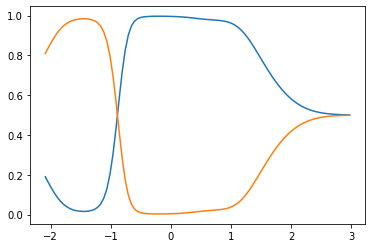

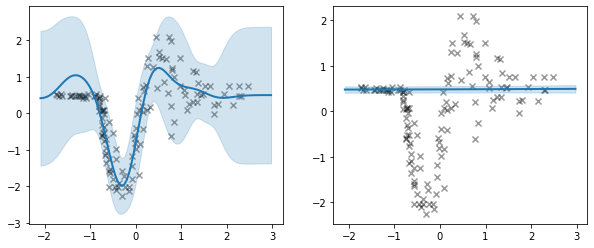

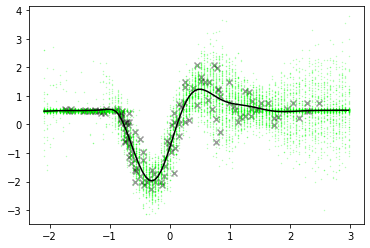

In [22]:
plotter.plot_model()